In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score,  RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter

# Models - Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

#Synthetic Minority Oversampling Technique
from imblearn.over_sampling import SMOTE

# Saving model
import joblib


## 🧩 **Step 4: Классификация**

### 📌 **Инструкция:**

1️⃣ **Бинаризация целевого столбца (1 этап)**  
Округлите рейтинги до ближайшего целого числа (`0-5`).  
Используйте их как **классы для обучения моделей классификации**.

---

2️⃣ **Модели классификации**  
Попробуйте **разные алгоритмы и их гиперпараметры** для предсказания классов
Выберите лучший вариант с помощью **перекрёстной проверки** и оцените показатель **accuracy (точность)** на тестовой подвыборке.

---

3️⃣ **Наивная модель (Baseline)**  
Рассчитайте **accuracy для наивного классификатора**, который всегда предсказывает **наиболее распространённый класс**.  
Сравните результаты с построенными моделями.

---

4️⃣ **Переход к 3 классам (2 этап)**  
Снова преобразуйте целевой столбец в 3 класса:
- **bad**: (0, 1)
- **so-so**: (2, 3)
- **great**: (4, 5)

Обучите модели классификации с новым разбиением и сравните их показатели accuracy.

---

5️⃣ **Анализ ошибок**  
Подумайте:

> ❓ Что хуже:  
> предсказать плохой рейтинг, который окажется хорошим, или предсказать хороший рейтинг, который окажется плохим?

Если нужно, замените метрику `accuracy` на:
- `precision`
- `recall`
- `F1-score`
- или кастомную метрику, учитывающую приоритеты Nutritionist.

---

6️⃣ **Ансамбли**  
Попробуйте **ансамбли и их гиперпараметры**:
- StackingClassifier
- VotingClassifier
- BaggingClassifier
- RandomForest
- XGBoost

Выберите лучший вариант с помощью **кросс-валидации** и проверьте результат на тестовой подвыборке.

---

🎯 **Цель:**
- Найти **лучшую классификационную модель** для предсказания класса качества блюда по ингредиентам.
- Сравнить её с регрессией и выбрать подходящий вариант для проекта **Nutritionist**.
- Подготовить модель для интеграции в CLI Nutritionist для практической работы.


In [10]:
df=pd.read_csv('data/epi_r.csv')

In [ ]:
ingredients = [
    "rating", "almond", "apple", "apricot", "artichoke", "arugula", "asian pear", "asparagus", "avocado",
    "bacon", "banana", "barley", "basil", "beef", "beet", "bell pepper",
    "berry", "blackberry", "blue cheese", "blueberry", "bok choy", "broccoli", "broccoli rabe", "brussel sprout",
    "butter", "buttermilk", "butternut squash", "cabbage", "capers", "carrot", "cashew",
    "cauliflower", "celery", "cheese", "cherry", "chestnut", "chickpea", "chile", "chile pepper", "chili",
    "chive", "chocolate", "cilantro", "cinnamon", "clove", "coconut", "cod", "collard greens",
    "corn", "cornmeal", "cottage cheese", "crab", "cranberry", "cream cheese", "cucumber", "cumin", "currant", "curry",
    "date", "dill", "egg", "eggplant", "endive", "feta", "fig", "fish", "fontina",
    "garlic", "ginger", "goat cheese", "gouda", "grape", "grapefruit", "green bean",
    "green onion/scallion", "ground beef", "ground lamb", "guava", "hazelnut", "honey", "honeydew", "horseradish",
    "hot pepper", "jalapeño", "jam or jelly", "kale", "lamb",
    "lentil", "lettuce", "lima bean", "lime", "lobster",
    "macadamia nut", "mango", "maple syrup", "melon", "mint", "molasses", "monterey jack", "mozzarella", "mushroom",
    "mussel", "mustard", "mustard greens", "nutmeg", "oat", "okra", "olive", "onion", "orange",
    "oregano", "orzo", "oyster", "parmesan", "parsley", "parsnip", "pea", "peach", "peanut", "peanut butter",
    "pear", "pecan", "pepper", "persimmon", "pine nut", "pineapple", "pistachio", "plantain", "plum", "pomegranate",
    "pork", "potato", "prune", "pumpkin", "quince", "quinoa", "radicchio", "radish", "raisin", "raspberry",
    "rhubarb", "rice", "ricotta", "root vegetable", "rosemary", "rye",
    "sage", "salmon", "sardine", "sausage", "scallop", "sesame",
    "sesame oil", "shallot", "shellfish", "shrimp", "snapper", "soy", "spinach", "squash", "squid", "strawberry",
    "sugar snap pea", "sweet potato/yam", "tilapia", "tofu", "tomatillo", "tomato", "tree nut", "turnip",
    "vanilla", "veal", "vinegar", "wasabi", "watercress", "watermelon", "wild rice", "yogurt", "yuca",
    "zucchini", "marshmallow","milk", "jam"
]

In [12]:
df = df[ingredients]

In [13]:
min_occurrences = 10

ingredient_counts = df.sum().sort_values(ascending=False)
ingredient_counts

frequent_cols = ingredient_counts[ingredient_counts >= min_occurrences].index.tolist()

In [14]:
df=df[frequent_cols]

In [15]:
X = df.drop(columns=['rating'])
y = df['rating']

X.head()

,onion,tomato,egg,garlic,cheese,ginger,potato,fish,pork,chocolate,...,guava,plantain,asian pear,rye,wild rice,radicchio,chile,tilapia,persimmon,gouda
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
binarized_y = y.round()

X_train, X_test, y_train, y_test = train_test_split(X, binarized_y, test_size=0.2, random_state=21, stratify=binarized_y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
print('\n y_test \n',y_test.value_counts())
print('\n y_train \n',y_train.value_counts())



 y_test 
 rating
4.0    2638
5.0     544
0.0     367
3.0     298
2.0     131
1.0      33
Name: count, dtype: int64

 y_train 
 rating
4.0    10550
5.0     2175
0.0     1469
3.0     1191
2.0      525
1.0      131
Name: count, dtype: int64


## 🎯 Точность базовой модели (Baseline Accuracy)

---

### 🩶 **Что это:**  
Доля правильных предсказаний, если **всегда предсказывать самый частый класс (моду)** в данных.

---

### 🛠️ **Зачем нужно:**  
Используется как **точка отсчета (baseline)** для оценки, лучше ли твоя модель, чем простое угадывание.

Если модель даёт точность, близкую к baseline, значит, она **не извлекает полезные закономерности**.

---

### 📐 **Формула:**
$$

\text{Baseline Accuracy} = \frac{\text{Количество примеров самого частого класса}}{\text{Общее количество примеров}}

$$
---


In [28]:
most_common_class = y_test.mode()[0]
baseline_accuracy = (y_test == most_common_class).mean()
print(f"Baseline Accuracy (predicting {most_common_class} always): {baseline_accuracy:.4f}")

Baseline Accuracy (predicting 4.0 always): 0.6577


## Logistic Regression

In [17]:
logreg=LogisticRegression(random_state=21,class_weight='balanced')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

In [18]:
param_grid_logreg = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.005, 0.01, 0.05, 0.1],
    'solver': ['liblinear'],
    'max_iter': [2000]
}

grid_logreg = GridSearchCV(
    logreg,
    param_grid_logreg,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,  
    verbose=2
)

grid_logreg.fit(X_train_scaled, y_train)


best_logreg = grid_logreg.best_estimator_
y_pred = best_logreg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV] END C=0.001, max_iter=2000, penalty=l1, solver=liblinear; total time=   2.1s
[CV] END C=0.001, max_iter=2000, penalty=l1, solver=liblinear; total time=   2.0s
[CV] END C=0.001, max_iter=2000, penalty=l1, solver=liblinear; total time=   2.2s
[CV] END C=0.001, max_iter=2000, penalty=l1, solver=liblinear; total time=   2.9s
[CV] END C=0.001, max_iter=2000, penalty=l1, solver=liblinear; total time=   2.8s
[CV] END C=0.005, max_iter=2000, penalty=l1, solver=liblinear; total time=   3.2s
[CV] END C=0.005, max_iter=2000, penalty=l1, solver=liblinear; total time=   3.5s
[CV] END C=0.005, max_iter=2000, penalty=l1, solver=liblinear; total time=   4.6s
[CV] END C=0.005, max_iter=2000, penalty=l1, solver=liblinear; total time=   4.6s
[CV] END C=0.005, max_iter=2000, penalty=l1, solver=liblinear; total time=   3.9s
[CV] END C=0.01, max_iter=2000, penalty=l1, solver=liblinear; total time=   3.8s
[CV] END C=0.01, max_iter=2000, penalty=l1, solver=liblinear; total time=   4.2s
[CV] END C=0.001, 

In [19]:
print("Best Parameters:", grid_logreg.best_params_)
print(f"Best Random Forest Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'C': 0.001, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}
Best Random Forest Test Accuracy: 0.6577

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       367
         1.0       0.00      0.00      0.00        33
         2.0       0.00      0.00      0.00       131
         3.0       0.00      0.00      0.00       298
         4.0       0.66      1.00      0.79      2638
         5.0       0.00      0.00      0.00       544

    accuracy                           0.66      4011
   macro avg       0.11      0.17      0.13      4011
weighted avg       0.43      0.66      0.52      4011



/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

### 📌 Вывод:
> - **Logistic Regression не подходит для задачи классификации рейтингов блюда с текущими данными.**

> - **Accuracy = 66% обусловлено угадыванием доминантного класса, не качеством предсказания.**

> - **Нужны более сложные модели.**

## RandomForestClassifier

In [20]:
rf = RandomForestClassifier(random_state=21, class_weight='balanced', n_jobs=-1)

In [21]:
param_grid_rf = {
    'n_estimators': [100, 200],        # Кол-во деревьев
    'max_depth': [None, 10, 20],       # Глубина деревьев
    'min_samples_split': [2, 5],       # Минимум для разбиения
    'min_samples_leaf': [1, 2],        # Минимум в листе
    'max_features': ['sqrt'],          # Стратегия выбора признаков
}

grid_rf = GridSearchCV(
    rf,
    param_grid_rf,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_train_scaled, y_train)


best_rf = grid_rf.best_estimator_
y_pred = best_rf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  17.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  19.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  22.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2,

/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  33.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  12.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  13.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  19.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  14.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  14.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  20.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  14.4s
[CV] END max_depth=None,

In [22]:
print("Best Parameters:", grid_rf.best_params_)
print(f"Best Random Forest Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Test Accuracy: 0.4682

Classification Report:
               precision    recall  f1-score   support

         0.0       0.23      0.47      0.31       367
         1.0       0.03      0.15      0.05        33
         2.0       0.06      0.18      0.10       131
         3.0       0.17      0.17      0.17       298
         4.0       0.76      0.57      0.65      2638
         5.0       0.29      0.22      0.25       544

    accuracy                           0.47      4011
   macro avg       0.26      0.30      0.25      4011
weighted avg       0.58      0.47      0.51      4011



### 📌 Вывод по **Random Forest**

> - **Random Forest пытается предсказывать все классы, а не только доминантный (4.0), поэтому accuracy ниже baseline (47% vs 66%).**

> - **Модель показывает неплохой recall по редким классам (например, 0.0 = 47%), но precision остаётся низким, что говорит о высокой доле ложных срабатываний.**

> - **Macro F1 = 0.25 указывает на слабое качество модели по всем классам, несмотря на высокую F1 у класса 4.0.**

> - **Модель лучше baseline только если задача — предсказывать редкие классы, но в текущем виде Random Forest недостаточно хорош для практического использования.**

> - **Необходима более мощная модель (например, XGBoost) и/или улучшение данных (SMOTE, downsampling, новые фичи) для повышения качества классификации.**


## XGBClassifier

In [39]:
xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=6,
    tree_method='hist',   # корректный метод
    device='cuda',        # использовать GPU
    random_state=21,
    verbosity=1
)

In [40]:
param_dist_xgb = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1],
    'n_estimators': [200], 
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist_xgb,
    n_iter=15,                  # пробуем 15 случайных комбинаций
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=21
)

In [42]:
random_search_xgb.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:21:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:21:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordin

[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1; total time=  40.0s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time=  40.3s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time=  40.5s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:21:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:21:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordin

[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1; total time=  40.6s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1; total time=  40.8s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:21:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1; total time=  41.3s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:21:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:21:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordin

[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time=  41.6s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time=  41.6s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:21:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1; total time=  41.9s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:21:44] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time=  42.2s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:22:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:22:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordin

[CV] END learning_rate=0.05, max_depth=10, n_estimators=200, subsample=0.8; total time= 1.5min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=200, subsample=0.8; total time= 1.5min


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:22:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:22:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordin

[CV] END learning_rate=0.05, max_depth=10, n_estimators=200, subsample=0.8; total time= 1.5min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=200, subsample=0.8; total time= 1.5min


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:22:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:22:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordin

[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=1; total time= 1.5min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=200, subsample=0.8; total time= 1.5min
[CV] END learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time= 1.1min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=1; total time= 1.5min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=200, subsample=1; total time= 1.5min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=1; total time= 1.5min
[CV] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=  40.9s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=  41.3s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=200, subsample=1; total time= 1.5min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=200, subsample=1; total time= 1.5min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsamp

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=21, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           gr...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=6, ...),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 6, 10],
                                        'n_estimators': [200],
                                        'subsample': [0.8, 1]},
                   random_state=21, scoring='accuracy', verbose=2)

In [43]:
best_xgb = random_search_xgb.best_estimator_
y_pred = best_xgb.predict(X_test_scaled)

/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:27:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [45]:
print(f"\nBest Parameters: {random_search_xgb.best_params_}")
print(f"Best XGBClassifier Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))


Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
Best XGBClassifier Test Accuracy: 0.6574

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.22      0.01      0.01       367
         1.0       0.00      0.00      0.00        33
         2.0       0.00      0.00      0.00       131
         3.0       0.00      0.00      0.00       298
         4.0       0.66      1.00      0.79      2638
         5.0       0.33      0.01      0.01       544

    accuracy                           0.66      4011
   macro avg       0.20      0.17      0.14      4011
weighted avg       0.50      0.66      0.52      4011



/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

### 📌 Вывод по **XGBClassifier**

> ✅ **Модель нашла лучшие параметры:**
> ```python
> {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
> ```
> 
> ✅ **Test Accuracy = 66%**, что совпадает с **baseline accuracy**, когда всегда предсказываем класс 4.0.
>
> ✅ **Recall для класса 4.0 = 1.0**, модель всегда предсказывает этот класс.
>
> ⚠️ **Остальные классы практически не предсказываются (precision и recall ≈ 0), macro avg F1 = 0.14.**
>
> ⚠️ Модель не извлекает закономерности для редких классов, поэтому **не лучше простого угадывания самого частого класса.**
>
> ---
>
> ## 🛠️ Рекомендации:
> - Применить **SMOTE или upsampling** для борьбы с дисбалансом классов.
> - Рассмотреть **sample_weight или class_weight** для XGBoost в мультиклассе.

In [47]:
def binarize_target(rating):
    if rating <= 1:
        return 'bad'
    elif rating <= 3:
        return "so-so"
    else:
        return "great"

In [48]:
y_class = y.apply(binarize_target)

In [49]:
y_class.value_counts()

rating
great    17396
bad       1836
so-so      820
Name: count, dtype: int64

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=21, stratify=y_class)


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Baseline Accuracy для y_class

In [55]:
most_common_class = y_test.mode()[0]
baseline_accuracy = (y_test == most_common_class).mean()
print(f"Baseline Accuracy (predicting '{most_common_class}' always): {baseline_accuracy:.4f}")

Baseline Accuracy (predicting 'great' always): 0.8676


## XGBClassifier

In [67]:
param_dist_xgb = {
    'max_depth': [3, 6, 10, 12],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1],
    'n_estimators': [200, 300], 
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist_xgb,
    n_iter=15,                
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=21
)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

fit_params = {
    "early_stopping_rounds": 10,
    "eval_metric": "mlogloss",
    "eval_set": [(X_test_scaled, y_test)],
    "verbose": False
}

In [68]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [69]:
random_search_xgb.fit(
    X_train_scaled,
    y_train_enc,
    sample_weight=sample_weights
)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:58:06] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=  35.5s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:58:06] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:58:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordin

[CV] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=  35.8s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=  35.8s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=  35.9s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=  35.9s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:58:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=6, n_estimators=300, subsample=0.8; total time=  47.9s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:58:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=6, n_estimators=300, subsample=0.8; total time=  52.9s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:58:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=6, n_estimators=300, subsample=0.8; total time=  53.4s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:58:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=6, n_estimators=300, subsample=0.8; total time=  53.9s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:58:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=6, n_estimators=300, subsample=0.8; total time=  54.5s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:58:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=12, n_estimators=300, subsample=1; total time= 1.5min


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:58:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=12, n_estimators=300, subsample=1; total time= 1.5min


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:58:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=12, n_estimators=300, subsample=1; total time= 1.5min


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:59:00] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=12, n_estimators=300, subsample=1; total time= 1.5min


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:59:00] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:59:00] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordin

[CV] END learning_rate=0.01, max_depth=12, n_estimators=300, subsample=0.8; total time= 1.5min
[CV] END learning_rate=0.005, max_depth=12, n_estimators=300, subsample=1; total time= 1.5min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time= 1.2min
[CV] END learning_rate=0.01, max_depth=12, n_estimators=300, subsample=0.8; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=12, n_estimators=300, subsample=0.8; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=12, n_estimators=300, subsample=0.8; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=12, n_estimators=300, subsample=0.8; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time= 1.2min
[CV] END learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1; total time=  33.4s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:59:36] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time= 1.2min
[CV] END learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1; total time=  34.9s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time= 1.2min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time= 1.2min


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [21:59:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.1, max_depth=10, n_estimators=300, subsample=0.8; total time= 1.2min
[CV] END learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1; total time=  33.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1; total time=  32.6s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1; total time=  32.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=300, subsample=0.8; total time= 1.2min
[CV] END learning_rate=0.1, max_depth=10, n_estimators=300, subsample=0.8; total time= 1.2min
[CV] END learning_rate=0.1, max_depth=10, n_estimators=300, subsample=0.8; total time= 1.2min
[CV] END learning_rate=0.1, max_depth=10, n_estimators=300, subsample=0.8; total time= 1.2min
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=1; total time=  47.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=1; total time=  47.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=

/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:00:22] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=1; total time=  48.4s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=1; total time=  48.1s
[CV] END learning_rate=0.005, max_depth=10, n_estimators=200, subsample=0.8; total time=  48.3s
[CV] END learning_rate=0.005, max_depth=10, n_estimators=200, subsample=0.8; total time=  48.0s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:00:29] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=10, n_estimators=200, subsample=0.8; total time=  49.1s
[CV] END learning_rate=0.005, max_depth=10, n_estimators=200, subsample=0.8; total time=  48.9s
[CV] END learning_rate=0.005, max_depth=10, n_estimators=200, subsample=0.8; total time=  49.6s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.6; total time=  51.2s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.6; total time=  50.5s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.6; total time=  51.0s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.6; total time=  52.1s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.6; total time=  52.4s
[CV] END learning_rate=0.005, max_depth=12, n_estimators=300, subsample=0.8; total time= 1.4min
[CV] END learning_rate=0.005, max_depth=12, n_estimators=300, subsample=0.8; total time= 1.4min
[CV] END learning_rate=0.1, max_depth=10, n_estimators=

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=21, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           gr...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=6, ...),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'learning_rate': [0.005, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [3, 6, 10, 12],
                                        'n_estimators': [200, 300],
                                        'subsample': [0.6, 0.8, 1]},
                   random_state=21, scoring='accuracy', verbose=2)

In [72]:
print(f"\nBest Parameters: {random_search_xgb.best_params_}")
y_pred = random_search_xgb.predict(X_test_scaled)
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1}
              precision    recall  f1-score   support

         bad       0.21      0.53      0.30       367
       great       0.92      0.65      0.76      3480
       so-so       0.07      0.26      0.11       164

    accuracy                           0.62      4011
   macro avg       0.40      0.48      0.39      4011
weighted avg       0.82      0.62      0.69      4011



### 📌 Вывод по XGBClassifier на 3 классах ("bad", "so-so", "great")

> ✅ **Accuracy = 62%**, что **значительно ниже baseline (86.8%)**, достигаемого при угадывании только класса "great".

> ⚠️ Падение accuracy объясняется тем, что **модель начала различать редкие классы ("bad", "so-so"), а не просто угадывать "great".**

---

> ✅ **Recall по классам:**
> - "bad" = 0.53 → модель **научилась находить плохие блюда**.
> - "so-so" = 0.26 → **слабо различает "так себе"**, но лучше, чем нулевой recall.
> - "great" = 0.65 → предсказывает хорошо, но **хуже baseline (86.8%)**.

---

> ✅ **Macro avg F1 = 0.39**, показывает, что модель **начала предсказывать редкие классы, улучшая сбалансированность предсказаний**.

> ⚠️ **Weighted avg F1 = 0.69** остаётся высоким за счёт доминирования класса "great".

---

> ⚠️ **Модель всё ещё чувствительна к дисбалансу**, но теперь **предсказывает больше, чем просто "great", делая её более полезной для практических целей, несмотря на снижение accuracy.**

---

## 🛠️ Рекомендации:
- Применить **SMOTE или upsampling**, чтобы улучшить предсказание класса "so-so".
- Использовать **sample_weight** или ручную балансировку весов классов.
- Рассмотреть **cost-sensitive learning или изменение порогов**, чтобы снизить риск ошибок по классу "bad", если они критичны для бизнеса.


----

### 📌 Что такое **SMOTE** и зачем он нужен

**SMOTE (Synthetic Minority Oversampling Technique)** — метод увеличения количества данных **для редких (миноритарных) классов** в несбалансированных наборах данных.

---

## 🩶 **Зачем нужен:**
- В реальных данных часто один класс **встречается намного чаще других**.
- Модель **учится игнорировать редкие классы**, предсказывая только доминирующий класс.
- **SMOTE помогает модели лучше распознавать редкие классы.**

---

## 🛠️ **Что делает SMOTE:**
- Создает **новые синтетические точки для миноритарных классов**, интерполируя существующие данные в признаковом пространстве.
- Делается **только на обучающих данных** перед обучением модели.
- Помогает модели **балансировать обучение между классами** и повышать **recall и F1 по редким классам**.

---

✅ SMOTE **не дублирует данные, а создает новые “похожие” объекты** для редких классов, делая тренировку более устойчивой и полезной в задачах **классификации с дисбалансом**.


In [75]:
smote = SMOTE(random_state=21)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_enc)

In [77]:
print("После SMOTE:", Counter(y_train_resampled))

После SMOTE: Counter({1: 13916, 0: 13916, 2: 13916})


In [78]:
random_search_xgb.fit(
    X_train_resampled,
    y_train_resampled
)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END learning_rate=0.005, max_depth=12, n_estimators=300, subsample=1; total time=  28.1s
[CV] END learning_rate=0.01, max_depth=12, n_estimators=300, subsample=0.8; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=12, n_estimators=300, subsample=0.8; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=12, n_estimators=300, subsample=0.8; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=12, n_estimators=300, subsample=0.8; total time=   1.6s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:14:45] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time= 1.2min


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:14:46] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time= 1.2min


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:14:46] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:14:46] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordin

[CV] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time= 1.2min
[CV] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time= 1.2min
[CV] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time= 1.2min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=300, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=300, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=300, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=300, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=300, subsample=0.8; total time=   0.9s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:15:16] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=6, n_estimators=300, subsample=0.8; total time= 1.7min


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:15:17] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=6, n_estimators=300, subsample=0.8; total time= 1.7min


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:15:18] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=6, n_estimators=300, subsample=0.8; total time= 1.7min


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:15:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=6, n_estimators=300, subsample=0.8; total time= 1.7min
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=1; total time=   0.7s


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:15:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=6, n_estimators=300, subsample=0.8; total time= 1.7min
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=1; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=1; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=1; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=1; total time=   0.9s
[CV] END learning_rate=0.005, max_depth=10, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.005, max_depth=10, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.005, max_depth=10, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.005, max_depth=10, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END learning_rate=0.005, max_depth=10, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.005, max_depth=12, n_estimators=

/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:16:18] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=12, n_estimators=300, subsample=1; total time= 2.7min


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:16:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.005, max_depth=12, n_estimators=300, subsample=1; total time= 2.7min
[CV] END learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1; total time= 1.0min


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:16:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:16:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordin

[CV] END learning_rate=0.01, max_depth=12, n_estimators=300, subsample=0.8; total time= 2.7min
[CV] END learning_rate=0.005, max_depth=12, n_estimators=300, subsample=1; total time= 2.7min[CV] END learning_rate=0.005, max_depth=12, n_estimators=300, subsample=1; total time= 2.7min

[CV] END learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1; total time= 1.1min


/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:16:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time= 2.3min
[CV] END learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.6; total time= 1.3min
[CV] END learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.6; total time= 1.3min
[CV] END learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.6; total time= 1.3min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time= 2.0min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time= 2.0min
[CV] END learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.6; total time= 1.0min
[CV] END learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.6; total time= 1.0min
[CV] END learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time=  51.8s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time=  41.8s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=300, su

/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
42 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/xgboost/sklearn.py", l

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=21, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           gr...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=6, ...),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'learning_rate': [0.005, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [3, 6, 10, 12],
                                        'n_estimators': [200, 300],
                                        'subsample': [0.6, 0.8, 1]},
                   random_state=21, scoring='accuracy', verbose=2)

In [79]:
y_pred = random_search_xgb.best_estimator_.predict(X_test_scaled)

In [80]:
print(f"\nTest Accuracy after SMOTE: {accuracy_score(y_test_enc, y_pred):.4f}")
print("\n=== Classification Report ===")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


Test Accuracy after SMOTE: 0.7175

=== Classification Report ===
              precision    recall  f1-score   support

         bad       0.22      0.46      0.29       367
       great       0.90      0.77      0.83      3480
       so-so       0.07      0.11      0.09       164

    accuracy                           0.72      4011
   macro avg       0.40      0.45      0.40      4011
weighted avg       0.81      0.72      0.75      4011



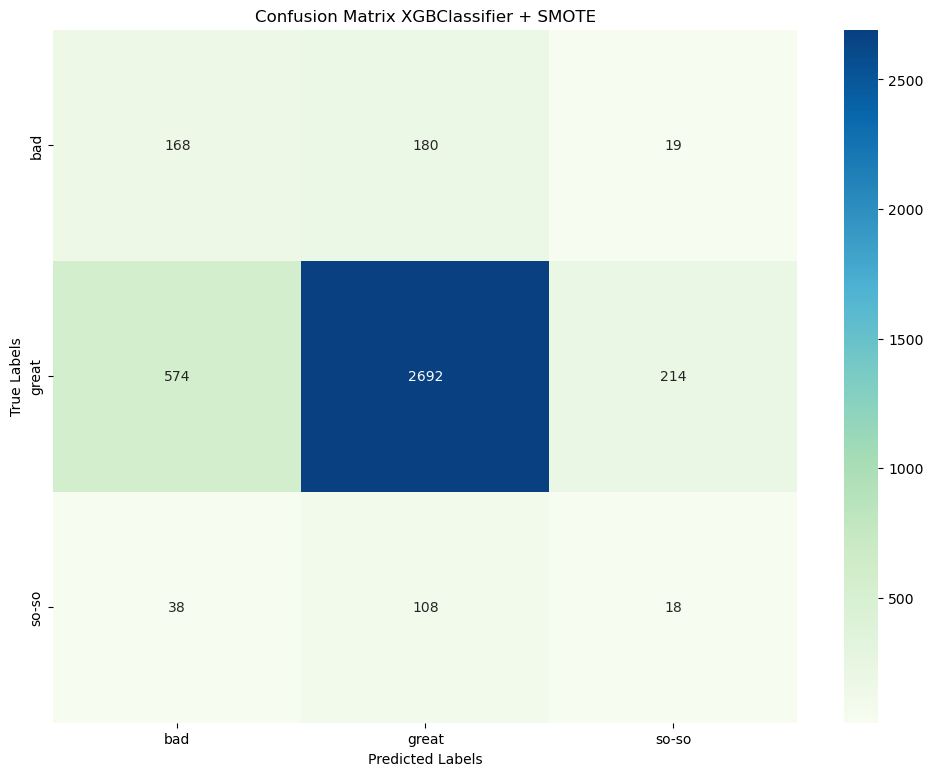

In [88]:
cm = confusion_matrix(y_test_enc, y_pred)


labels = le.classes_  # ['bad', 'great', 'so-so']

plt.figure(figsize=(12,9))
sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix XGBClassifier + SMOTE')
plt.show()

##  CatBoostClassifier

In [92]:
classes = np.unique(y_train_enc)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_enc)
class_weights = dict(zip(classes, weights))
print("Class Weights:", class_weights)

Class Weights: {0: 3.6398910823689583, 1: 0.38423397528025294, 2: 8.150914634146341}


In [99]:
cat_clf = CatBoostClassifier(
    task_type='GPU',
    devices='0',
    random_state=21,
    verbose=0,
    class_weights=class_weights
)


param_dist = {
    'iterations': [200, 300, 500],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1],
    'random_strength': [0.5, 1, 2]
}

In [100]:
random_search_cat = RandomizedSearchCV(
    estimator=cat_clf,
    param_distributions=param_dist,
    n_iter=30,                      # выбираем 30 случайных комбинаций
    scoring='accuracy',
    cv=cv,
    verbose=2,
    n_jobs=1,
    random_state=21
)

In [101]:
random_search_cat.fit(X_train_scaled, y_train_enc)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bagging_temperature=1, depth=8, iterations=300, l2_leaf_reg=1, learning_rate=0.01, random_strength=0.5; total time=   2.1s
[CV] END bagging_temperature=1, depth=8, iterations=300, l2_leaf_reg=1, learning_rate=0.01, random_strength=0.5; total time=   2.1s
[CV] END bagging_temperature=1, depth=8, iterations=300, l2_leaf_reg=1, learning_rate=0.01, random_strength=0.5; total time=   2.2s
[CV] END bagging_temperature=1, depth=8, iterations=300, l2_leaf_reg=1, learning_rate=0.01, random_strength=0.5; total time=   2.0s
[CV] END bagging_temperature=1, depth=8, iterations=300, l2_leaf_reg=1, learning_rate=0.01, random_strength=0.5; total time=   2.0s
[CV] END bagging_temperature=0.5, depth=6, iterations=300, l2_leaf_reg=5, learning_rate=0.03, random_strength=2; total time=   1.3s
[CV] END bagging_temperature=0.5, depth=6, iterations=300, l2_leaf_reg=5, learning_rate=0.03, random_strength=2; total time=   1.4s
[CV] END baggi

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x712c14cf9dd0>,
                   n_iter=30, n_jobs=1,
                   param_distributions={'bagging_temperature': [0, 0.5, 1],
                                        'depth': [4, 6, 8],
                                        'iterations': [200, 300, 500],
                                        'l2_leaf_reg': [1, 3, 5, 7],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'random_strength': [0.5, 1, 2]},
                   random_state=21, scoring='accuracy', verbose=2)

In [102]:
y_pred = random_search_cat.best_estimator_.predict(X_test_scaled)

In [103]:
print(f"\nBest Parameters: {random_search_cat.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test_enc, y_pred):.4f}")
print("\n=== Classification Report ===")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


Best Parameters: {'random_strength': 1, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 8, 'bagging_temperature': 0.5}
Test Accuracy: 0.5226

=== Classification Report ===
              precision    recall  f1-score   support

         bad       0.18      0.62      0.28       367
       great       0.93      0.53      0.67      3480
       so-so       0.05      0.26      0.09       164

    accuracy                           0.52      4011
   macro avg       0.39      0.47      0.35      4011
weighted avg       0.82      0.52      0.61      4011



In [105]:
random_search_cat.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bagging_temperature=1, depth=8, iterations=300, l2_leaf_reg=1, learning_rate=0.01, random_strength=0.5; total time=   4.5s
[CV] END bagging_temperature=1, depth=8, iterations=300, l2_leaf_reg=1, learning_rate=0.01, random_strength=0.5; total time=   4.3s
[CV] END bagging_temperature=1, depth=8, iterations=300, l2_leaf_reg=1, learning_rate=0.01, random_strength=0.5; total time=   4.5s
[CV] END bagging_temperature=1, depth=8, iterations=300, l2_leaf_reg=1, learning_rate=0.01, random_strength=0.5; total time=   4.4s
[CV] END bagging_temperature=1, depth=8, iterations=300, l2_leaf_reg=1, learning_rate=0.01, random_strength=0.5; total time=   4.4s
[CV] END bagging_temperature=0.5, depth=6, iterations=300, l2_leaf_reg=5, learning_rate=0.03, random_strength=2; total time=   2.9s
[CV] END bagging_temperature=0.5, depth=6, iterations=300, l2_leaf_reg=5, learning_rate=0.03, random_strength=2; total time=   2.7s
[CV] END baggi

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x712c14cf9dd0>,
                   n_iter=30, n_jobs=1,
                   param_distributions={'bagging_temperature': [0, 0.5, 1],
                                        'depth': [4, 6, 8],
                                        'iterations': [200, 300, 500],
                                        'l2_leaf_reg': [1, 3, 5, 7],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'random_strength': [0.5, 1, 2]},
                   random_state=21, scoring='accuracy', verbose=2)

In [106]:
y_pred = random_search_cat.best_estimator_.predict(X_test_scaled)

In [107]:
print(f"\nBest Parameters: {random_search_cat.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test_enc, y_pred):.4f}")
print("\n=== Classification Report ===")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


Best Parameters: {'random_strength': 2, 'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 300, 'depth': 8, 'bagging_temperature': 0.5}
Test Accuracy: 0.1501

=== Classification Report ===
              precision    recall  f1-score   support

         bad       0.12      0.43      0.19       367
       great       0.96      0.10      0.18      3480
       so-so       0.05      0.65      0.08       164

    accuracy                           0.15      4011
   macro avg       0.38      0.39      0.15      4011
weighted avg       0.85      0.15      0.17      4011



### 📌 Вывод по CatBoost + SMOTE

> ❌ **Test Accuracy = 15%**, значительно ниже baseline (86.8%), что указывает на **сильный провал модели.**

> ✅ Модель стала лучше различать редкие классы:
> - Recall “bad” = 43% (↑)
> - Recall “so-so” = 65% (↑)
> - Но при этом Recall “great” = 10% (↓)

> ⚠️ Precision по “bad” и “so-so” крайне низкий, что говорит о большом количестве ложных срабатываний.

> ⚠️ Модель **сильно сместилась в сторону редких классов и потеряла способность распознавать “great”.**

> ❌ Итог: **SMOTE в связке с CatBoost на этом датасете привел к деградации качества модели.**

---

## 🛠️ Рекомендации:
- Использовать **CatBoost с class_weights без SMOTE**.
- Применить **threshold tuning (подбор порогов)** для улучшения recall по “bad” **без потери по “great”.
- Рассмотреть **cost-sensitive learning** и **feature engineering** для дальнейшего улучшения.


In [159]:
classes = np.unique(y_train_enc)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_enc)
class_weights = dict(zip(classes, weights))

In [163]:
cat_clf = CatBoostClassifier(
    task_type='GPU',
    devices='0',
    random_state=21,
    verbose=100,
    iterations=500,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=5,
    bagging_temperature=0.5,
    random_strength=1,
    class_weights=class_weights
)

In [164]:
cv_scores = cross_val_score(cat_clf, X_train_scaled, y_train_enc, cv=cv, scoring='accuracy', n_jobs=1)

print(f"\n✅ Cross-validation Accuracy (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

0:	learn: 1.0956429	total: 7.02ms	remaining: 3.5s
100:	learn: 0.9895641	total: 564ms	remaining: 2.23s
200:	learn: 0.9365365	total: 1.04s	remaining: 1.55s
300:	learn: 0.8977514	total: 1.51s	remaining: 996ms
400:	learn: 0.8656219	total: 1.96s	remaining: 485ms
499:	learn: 0.8393658	total: 2.44s	remaining: 0us
0:	learn: 1.0958122	total: 5.61ms	remaining: 2.8s
100:	learn: 0.9907759	total: 510ms	remaining: 2.01s
200:	learn: 0.9382840	total: 987ms	remaining: 1.47s
300:	learn: 0.8986127	total: 1.48s	remaining: 977ms
400:	learn: 0.8669923	total: 1.99s	remaining: 490ms
499:	learn: 0.8403004	total: 2.46s	remaining: 0us
0:	learn: 1.0956056	total: 6.01ms	remaining: 3s
100:	learn: 0.9877980	total: 468ms	remaining: 1.85s
200:	learn: 0.9339233	total: 921ms	remaining: 1.37s
300:	learn: 0.8948256	total: 1.39s	remaining: 918ms
400:	learn: 0.8631049	total: 1.87s	remaining: 462ms
499:	learn: 0.8366262	total: 2.33s	remaining: 0us
0:	learn: 1.0958755	total: 5.88ms	remaining: 2.93s
100:	learn: 0.9910312	total

In [165]:
cat_clf.fit(X_train_scaled, y_train_enc, eval_set=(X_test_scaled, y_test_enc), early_stopping_rounds=30)

0:	learn: 1.0957659	test: 1.0965637	best: 1.0965637 (0)	total: 9.03ms	remaining: 4.51s
100:	learn: 0.9959870	test: 1.0546247	best: 1.0545829 (99)	total: 547ms	remaining: 2.16s
200:	learn: 0.9469737	test: 1.0464303	best: 1.0464303 (200)	total: 1.04s	remaining: 1.55s
bestTest = 1.044129414
bestIteration = 260
Shrink model to first 261 iterations.


In [168]:
y_pred_cat_cv = cat_clf.predict(X_test_scaled)

In [169]:
print(f"\n Test Accuracy (CatBoost with CV & class_weights): {accuracy_score(y_test_enc, y_pred_cat_cv):.4f}")


 Test Accuracy (CatBoost with CV & class_weights): 0.5084


In [170]:
print("\n=== Classification Report ===")
print(classification_report(y_test_enc, y_pred_cat_cv, target_names=le.classes_))


=== Classification Report ===
              precision    recall  f1-score   support

         bad       0.17      0.62      0.27       367
       great       0.93      0.51      0.66      3480
       so-so       0.05      0.26      0.09       164

    accuracy                           0.51      4011
   macro avg       0.39      0.46      0.34      4011
weighted avg       0.83      0.51      0.60      4011



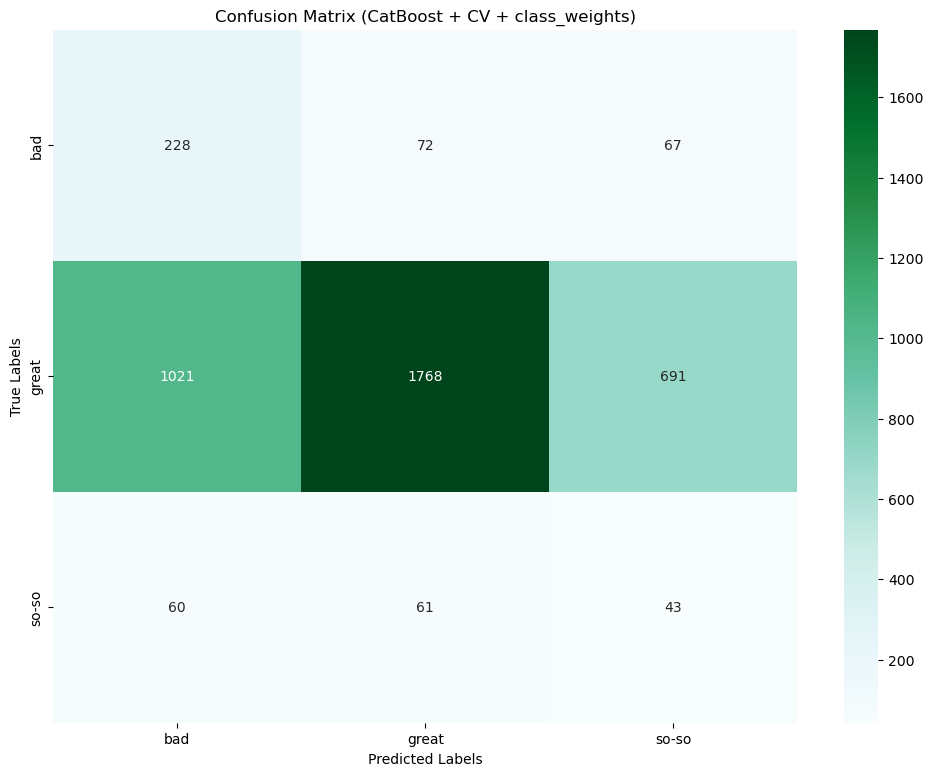

In [172]:
cm_cv = confusion_matrix(y_test_enc, y_pred_cat_cv)

plt.figure(figsize=(12, 9))
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='BuGn',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (CatBoost + CV + class_weights)')
plt.show()

##  Stacking ensembling

In [187]:
best_xgb_model = random_search_xgb.best_estimator_

meta_model = LogisticRegression(max_iter=1000, random_state=21)

In [188]:
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', best_xgb_model),
    ],
    final_estimator=cat_clf,
    cv=5,
    n_jobs=1,
    passthrough=True  
)

In [214]:
y_train_enc = np.ravel(y_train_enc)

In [218]:
stacking_clf.fit(X_train_scaled, y_train_enc)

0:	learn: 1.0912143	total: 6.34ms	remaining: 3.16s
100:	learn: 0.9475554	total: 580ms	remaining: 2.29s
200:	learn: 0.8901094	total: 1.15s	remaining: 1.71s
300:	learn: 0.8451822	total: 1.73s	remaining: 1.14s
400:	learn: 0.8072012	total: 2.34s	remaining: 577ms
499:	learn: 0.7741522	total: 2.9s	remaining: 0us


StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device='cuda',
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interactio...
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=300, n_jobs=None,
                                              num_class=6, ...))],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x712bdb5ef7d0>,
                   n_jobs=1, passthrough=True)

In [219]:
y_pred_stacking = stacking_clf.predict(X_test_scaled)

/home/perraseb/miniconda3/envs/ds_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [220]:
print(f"\nTest Accuracy (Stacking Ensemble): {accuracy_score(y_test_enc, y_pred_stacking):.4f}")


print("\n=== Classification Report ===")
print(classification_report(y_test_enc, y_pred_stacking, target_names=le.classes_))


Test Accuracy (Stacking Ensemble): 0.5969

=== Classification Report ===
              precision    recall  f1-score   support

         bad       0.20      0.59      0.30       367
       great       0.92      0.62      0.74      3480
       so-so       0.06      0.20      0.09       164

    accuracy                           0.60      4011
   macro avg       0.39      0.47      0.37      4011
weighted avg       0.82      0.60      0.67      4011



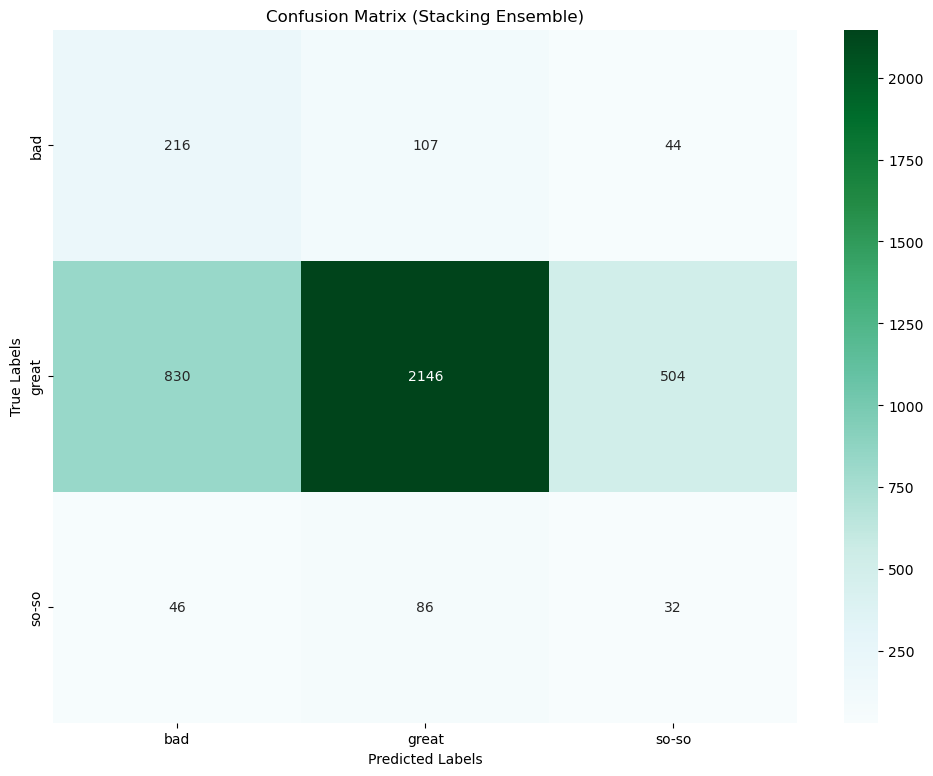

In [197]:
cm_stack = confusion_matrix(y_test_enc, y_pred_stacking)

plt.figure(figsize=(12, 9))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='BuGn',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Stacking Ensemble)')
plt.show()

### 📌 Итог по Stacking Ensemble (CatBoost meta, XGB base)

✅ **Test Accuracy = 59.7%** — ниже baseline (86.8%), но **это ожидаемо, так как модель теперь различает редкие классы.**

---

### **По классам:**
- **"bad":**
  - Recall = **0.59 (59%)**, важно, так как **нам критично находить плохие блюда**.
  - Precision = 0.20.
  - F1 = 0.30.
- **"so-so":**
  - Recall = 0.20 (видит часть “so-so”, что лучше, чем игнорирование).
- **"great":**
  - Recall = 0.62 (понизилось по сравнению с baseline, но приемлемо).

---

## 🩶 Вывод:
✅ Модель **смогла начать выявлять "bad" (59% recall)**, что **важнее для задачи, чем удержание высокой точности по "great".**

✅ Accuracy упала, **но модель стала практически полезной, так как выявляет потенциально плохие блюда, которые необходимо фильтровать.**

✅ **Это прогресс по сравнению с моделями, которые угадывали только "great".**

---


## Сохранение Stacking-модели

In [221]:
joblib.dump(stacking_clf, 'stacking_catboost_xgb_model.joblib')

['stacking_catboost_xgb_model.joblib']